# HR Analytics: Predicting Employee Retention

## Objective 
In this project, I aim to build a predictive model that identifies employees who are at risk of leaving a large consulting firm. By predicting potential turnover, the company could proactively address employee concerns and improve retention, thus saving on hiring and training costs.




### Data
I utilized an [HR dataset ↗](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv) from Kaggle. There are 14,999 rows, 10 columns, and these variables: 

Variable  |Description |
-----|-----| 
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

## Data Import and Cleaning



In [1]:
# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# For saving models
import pickle

### Check the structure and summary statistics.

In [2]:
# Load dataset into a dataframe
df0 = pd.read_csv("HR_capstone_dataset.csv")

# Display first few rows of the dataframe
df0.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
# Gather basic information about the data
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
# Gather descriptive statistics about the data
df0.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


### Rename columns

As part of cleaning, I standardize the column names to follow Python conventions and make them more concise.

In [5]:
# Display all column names
 
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [6]:
# Rename columns as needed
 
df0 = df0.rename(columns={'Work_accident': 'work_accident',
                          'average_montly_hours': 'average_monthly_hours',
                          'time_spend_company': 'tenure',
                          'Department': 'department'})

# Display all column names after the update
 
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

### Check missing values

In [7]:
# Check for missing values

df0.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

There are no missing values in the data.

### Check duplicates

In [8]:
# Check for duplicates

df0.duplicated().sum()

3008

3,008 rows contain duplicates. That is 20% of the data.

In [9]:
# Inspect some rows containing duplicates as needed

df0[df0.duplicated()].head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low


The data has no missing values, but I find a significant number of duplicate rows that appear to be redundant entries. I drop these duplicates to ensure data quality.

In [10]:
# Drop duplicates and save resulting dataframe in a new variable as needed

df1 = df0.drop_duplicates(keep='first')

# Display first few rows of new dataframe as needed
df1.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Check outliers

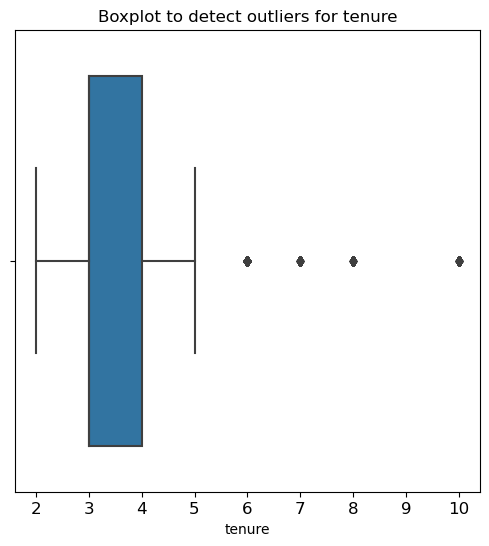

In [11]:
# Create a boxplot to visualize distribution of `tenure` and detect any outliers
plt.figure(figsize=(6,6))
plt.title('Boxplot to detect outliers for tenure', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df1['tenure'])
plt.show()

The boxplot above shows that there are outliers in the `tenure` variable. 
Outliers are defined as data lying outside 1.5 times interquartile range from 25th and 75th percentile. 
It would be helpful to investigate how many rows in the data contain outliers in the `tenure` column.



In [12]:
# Determine the number of rows containing outliers 

# Compute the 25th percentile value in `tenure`
percentile25 = df1['tenure'].quantile(0.25)

# Compute the 75th percentile value in `tenure`
percentile75 = df1['tenure'].quantile(0.75)

# Compute the interquartile range in `tenure`
iqr = percentile75 - percentile25

# Define the upper limit and lower limit for non-outlier values in `tenure`
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

# Identify subset of data containing outliers in `tenure`
outliers = df1[(df1['tenure'] > upper_limit) | (df1['tenure'] < lower_limit)]

# Count how many rows in the data contain outliers in `tenure`
print("Number of rows in the data containing outliers in `tenure`:", len(outliers))

Lower limit: 1.5
Upper limit: 5.5
Number of rows in the data containing outliers in `tenure`: 824


I decide not to handle outliers here because certain types of models are more sensitive to outliers than others. I will consider whether to remove them when I made a decision on the type of model to be used.

## Exploratory Data Analysis

To understand employee attrition, I first calculate the percentage who left versus stayed. Only about 17% left.

In [13]:
# Get numbers of people who left vs. stayed

print(df1['left'].value_counts())
print()

# Get percentages of people who left vs. stayed

print(df1['left'].value_counts(normalize=True))

0    10000
1     1991
Name: left, dtype: int64

0    0.833959
1    0.166041
Name: left, dtype: float64


Only about 17% left.

### Data visualizations

Next, I create visualizations to explore relationships between variables:

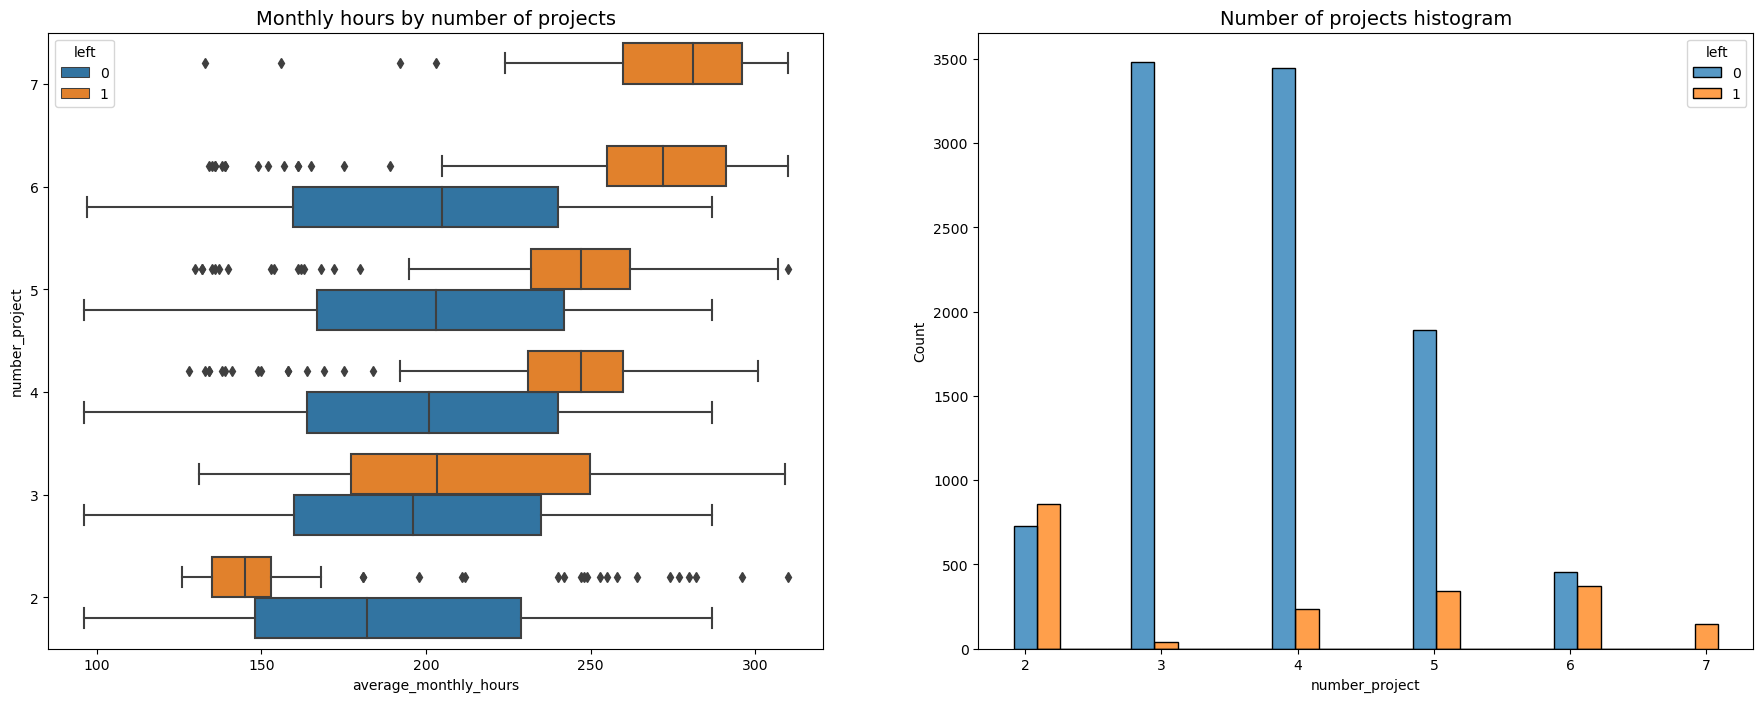

In [14]:
# Set figure and axes
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Create boxplot showing `average_monthly_hours` distributions for `number_project`, comparing employees who stayed versus those who left
sns.boxplot(data=df1, x='average_monthly_hours', y='number_project', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Monthly hours by number of projects', fontsize='14')

# Create histogram showing distribution of `number_project`, comparing employees who stayed versus those who left
tenure_stay = df1[df1['left']==0]['number_project']
tenure_left = df1[df1['left']==1]['number_project']
sns.histplot(data=df1, x='number_project', hue='left', multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('Number of projects histogram', fontsize='14')

# Display the plots
plt.show()

1. **Two types of leavers**: 
People who left the company are divided into two groups. Group A worked fewer hours than their peers, possibly because they were fired or were leaving anyway. Group B worked more hours, likely indicating they quit.

2. **Overworking leads to turnover**: 
All employees with seven projects left the company. They, along with those who left with six projects, worked 255–295 hours a week, which is a lot more than other groups.

3. **3-4 projects are optimal**: 
The smallest number of employees left the company when they were assigned 3–4 projects.

4. **Overwork is common**: 
Apart from those with two projects, all groups worked more than the average 166.67 hours a month, assuming a 40-hour work week and two weeks of vacation per year. This indicates widespread overwork.

As the next step, I confirm that all employees with seven projects left.

In [15]:
# Get value counts of stayed/left for employees with 7 projects
df1[df1['number_project']==7]['left'].value_counts()

1    145
Name: left, dtype: int64

This confirms that all employees with 7 projects did leave. 

Next, I examine the average monthly hours versus the satisfaction levels. 

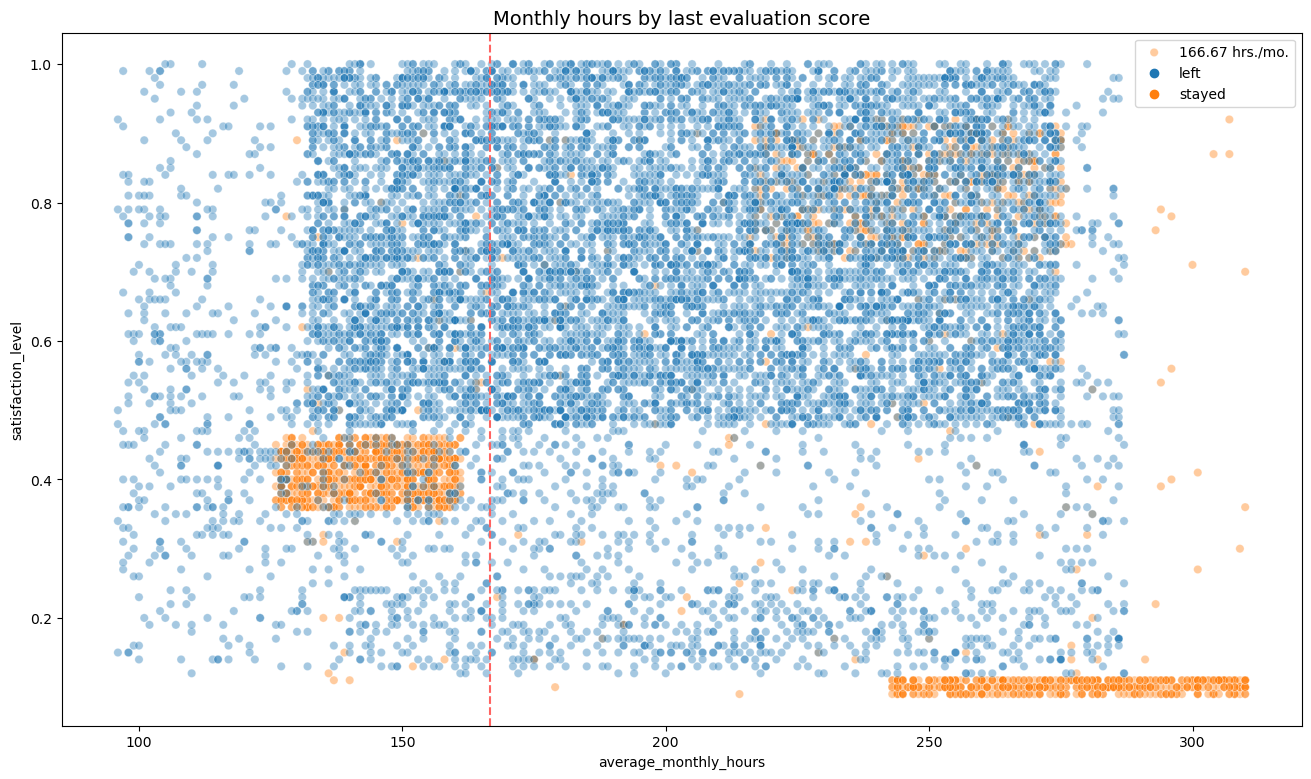

In [16]:
# Create scatterplot of `average_monthly_hours` versus `satisfaction_level`, comparing employees who stayed versus those who left
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df1, x='average_monthly_hours', y='satisfaction_level', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14');

1. **High work hours, low satisfaction**: A large group of employees worked an excessive 240–315 hours per month. This likely led to their extremely low satisfaction levels, close to zero.

2. **Normal hours, low satisfaction**: Another group worked regular hours, but their satisfaction was still low (around 0.4). They might have felt pressure to work more hours, leading to their low satisfaction and possible decision to leave.

3. **Moderate hours, high satisfaction**: A group that worked 210–280 hours per month had relatively high satisfaction levels (0.7–0.9).

Next, I visualize satisfaction levels by tenure.

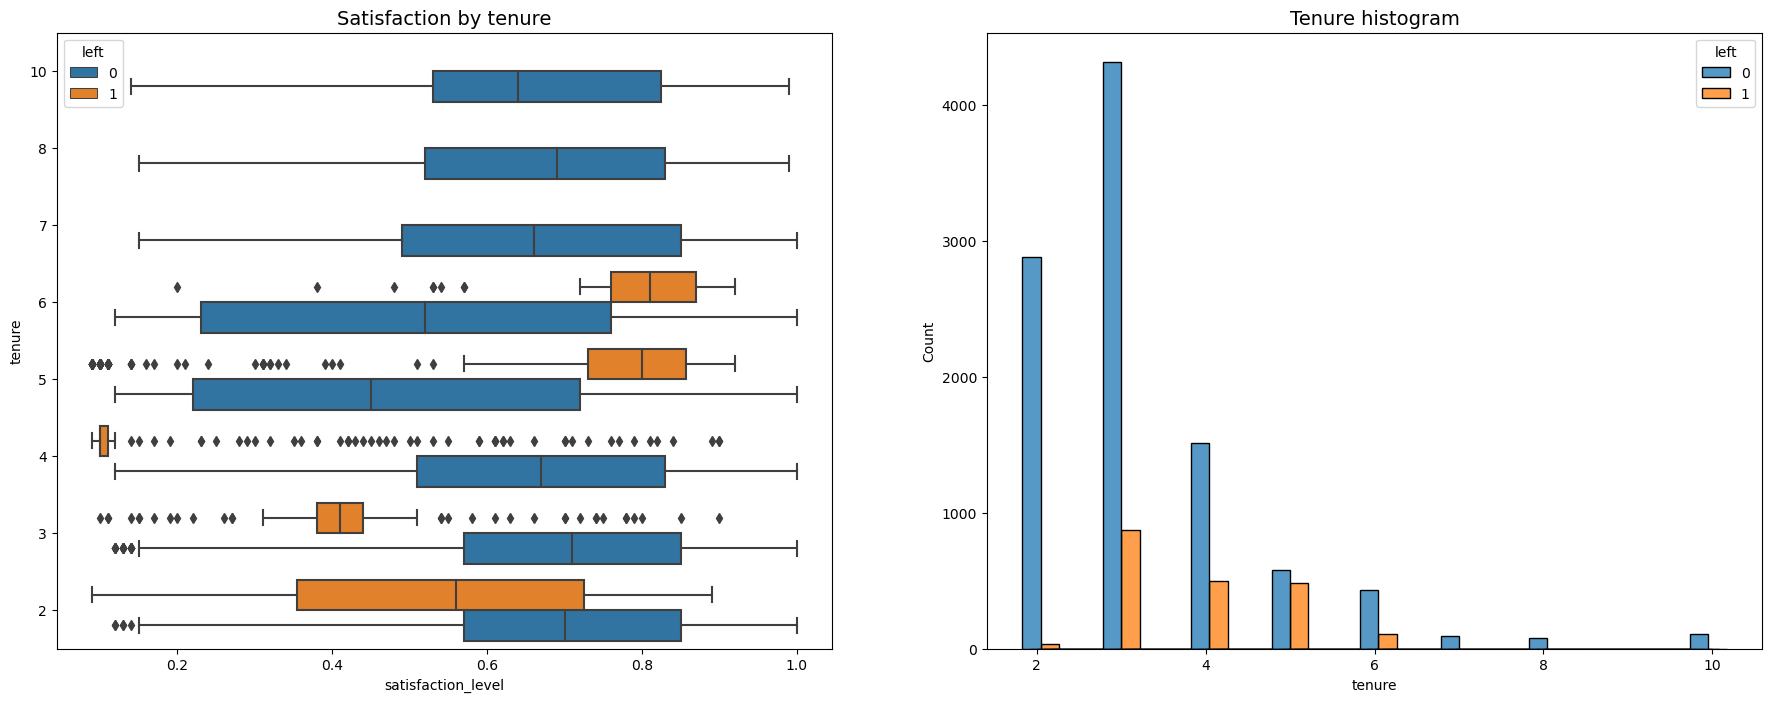

In [17]:
# Set figure and axes
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Create boxplot showing distributions of `satisfaction_level` by tenure, comparing employees who stayed versus those who left
sns.boxplot(data=df1, x='satisfaction_level', y='tenure', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction by tenure', fontsize='14')

# Create histogram showing distribution of `tenure`, comparing employees who stayed versus those who left
tenure_stay = df1[df1['left']==0]['tenure']
tenure_left = df1[df1['left']==1]['tenure']
sns.histplot(data=df1, x='tenure', hue='left', multiple='dodge', shrink=5, ax=ax[1])
ax[1].set_title('Tenure histogram', fontsize='14')

plt.show();

1. **Two types of leavers:** Employees who left are generally dissatisfied employees with short tenures, or very satisfied employees with medium-length tenures.

2. **Four-year mark:** Employees who left at the four-year mark had unusually low satisfaction. It may be useful to investigate any company changes around this time.

3. **Longest-tenured stayed:** The most experienced employees did not leave, and their satisfaction levels matched those of the newer employees who also stayed.

4. **Few long-term employees:** The histogram indicates fewer long-tenured employees, potentially higher-ranking and higher-paid.

Next, I calculate the mean and median satisfaction of employees who left and those who stayed.

In [18]:
# Calculate mean and median satisfaction scores of employees who left and those who stayed
df1.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])

,mean,median
left,,
0,0.667365,0.69
1,0.440271,0.41


1. **Lower satisfaction among leavers:** The average and median satisfaction scores of employees who left are lower than those who stayed.

2. **Possible left skew:** Among employees who stayed, the average satisfaction is lower than the median, suggesting that satisfaction scores could be left-skewed.

Next, I analyze salary levels across different lengths of tenure.

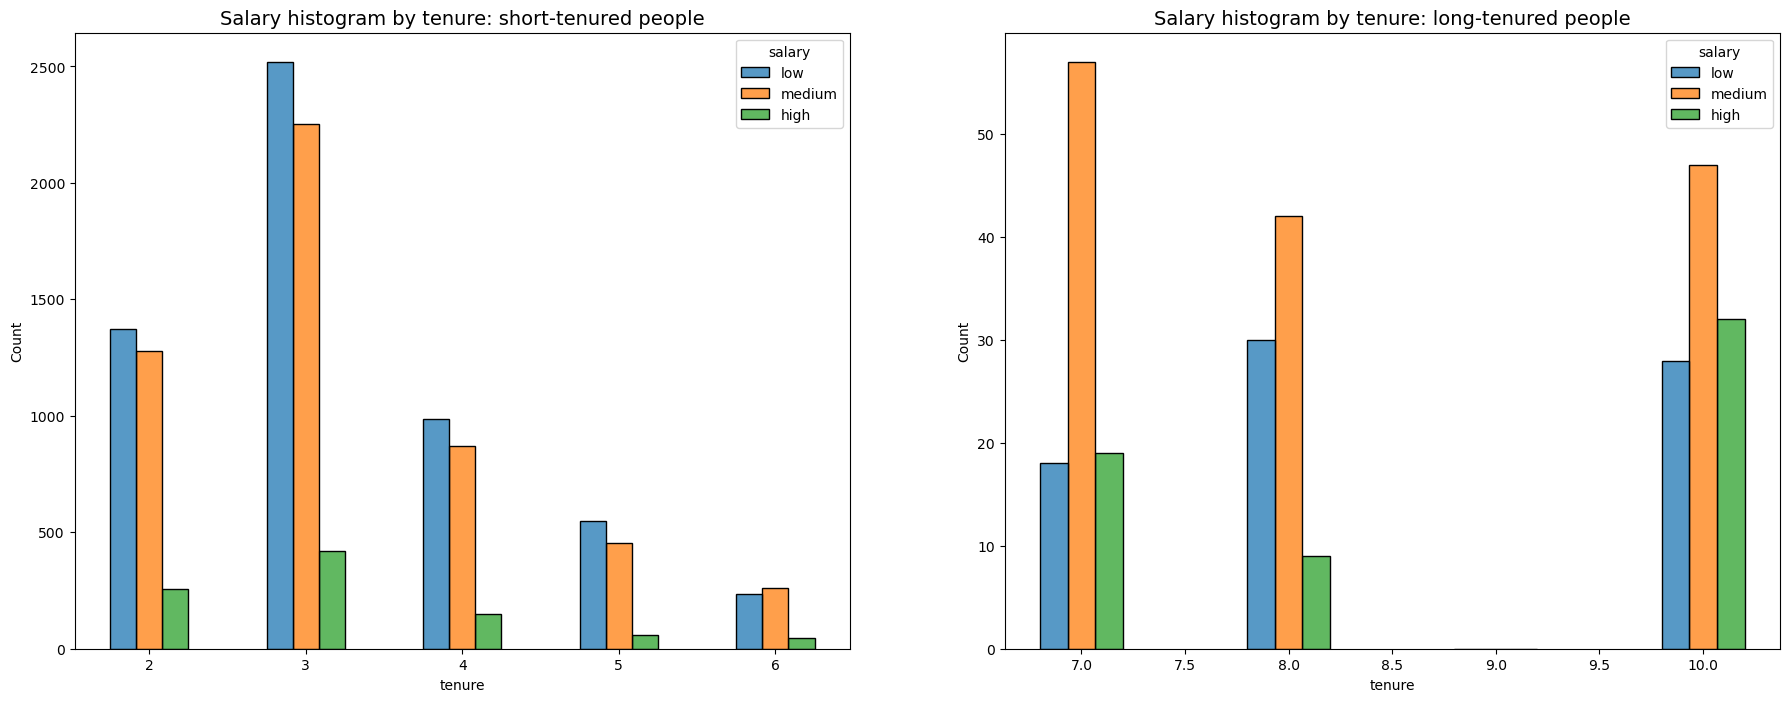

In [19]:
# Set figure and axes
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Define short-tenured employees
tenure_short = df1[df1['tenure'] < 7]

# Define long-tenured employees
tenure_long = df1[df1['tenure'] > 6]

# Plot short-tenured histogram
sns.histplot(data=tenure_short, x='tenure', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.5, ax=ax[0])
ax[0].set_title('Salary histogram by tenure: short-tenured people', fontsize='14')

# Plot long-tenured histogram
sns.histplot(data=tenure_long, x='tenure', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.4, ax=ax[1])
ax[1].set_title('Salary histogram by tenure: long-tenured people', fontsize='14');

 * **Diverse salary levels:** Long-tenured employees are not necessarily higher-paid.


Next, I investigate possible correlation between long work hours and high evaluation scores.

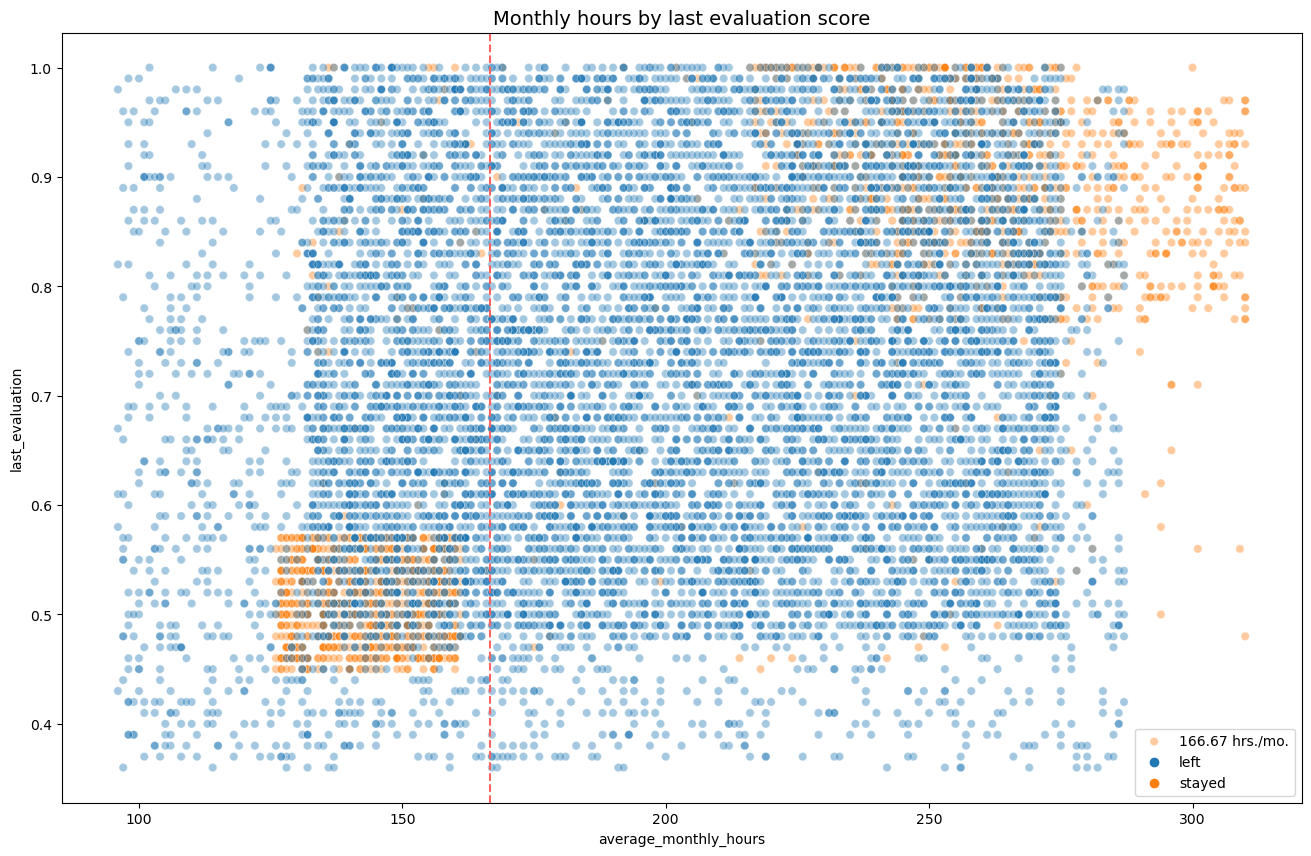

In [20]:
# Create scatterplot of `average_monthly_hours` versus `last_evaluation`
plt.figure(figsize=(16, 10))
sns.scatterplot(data=df1, x='average_monthly_hours', y='last_evaluation', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14');

1. **Two types of leavers:** Overworked, high-performing employees and employees working slightly less than average with lower evaluations left the company.
2. **Hours and evaluations linked:** There appears to be a correlation between work hours and evaluation scores.
3. **Long hours, low evaluations:** Working long hours doesn't always result in a high evaluation score.
4. **Overwork is common:** Most employees work more than 167 hours per month.


Next, I analyze promotions among employees who worked very long hours.

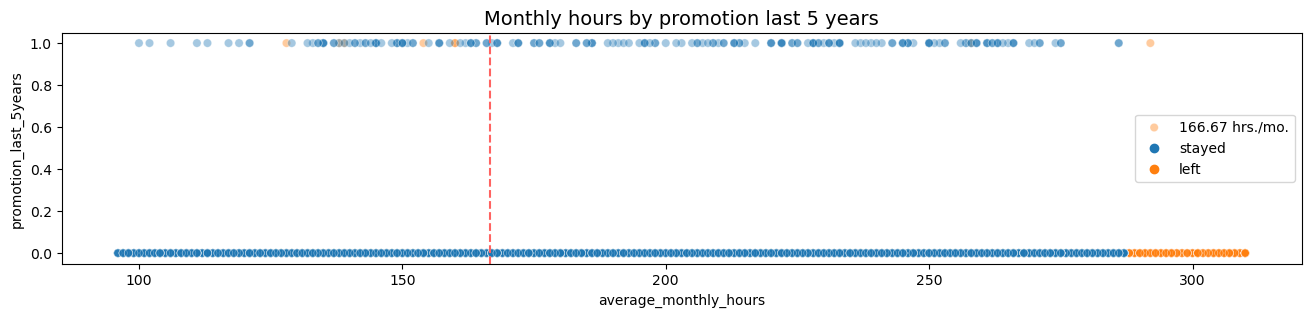

In [22]:
# Create plot to examine relationship between `average_monthly_hours` and `promotion_last_5years`
plt.figure(figsize=(16, 3))
sns.scatterplot(data=df1, x='average_monthly_hours', y='promotion_last_5years', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'stayed', 'left'])
plt.title('Monthly hours by promotion last 5 years', fontsize='14');

1. **Few promotions for leavers:** Not many employees who left had been promoted in the last five years.
2. **Few promotions for overworkers:** Employees working the most hours rarely got promoted.
3. **Overworkers leave:** All employees who left were among those working the longest hours.

Next, I examine departmental distribution of employees who left.

In [23]:
# Display counts for each department
df1["department"].value_counts()

sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: department, dtype: int64

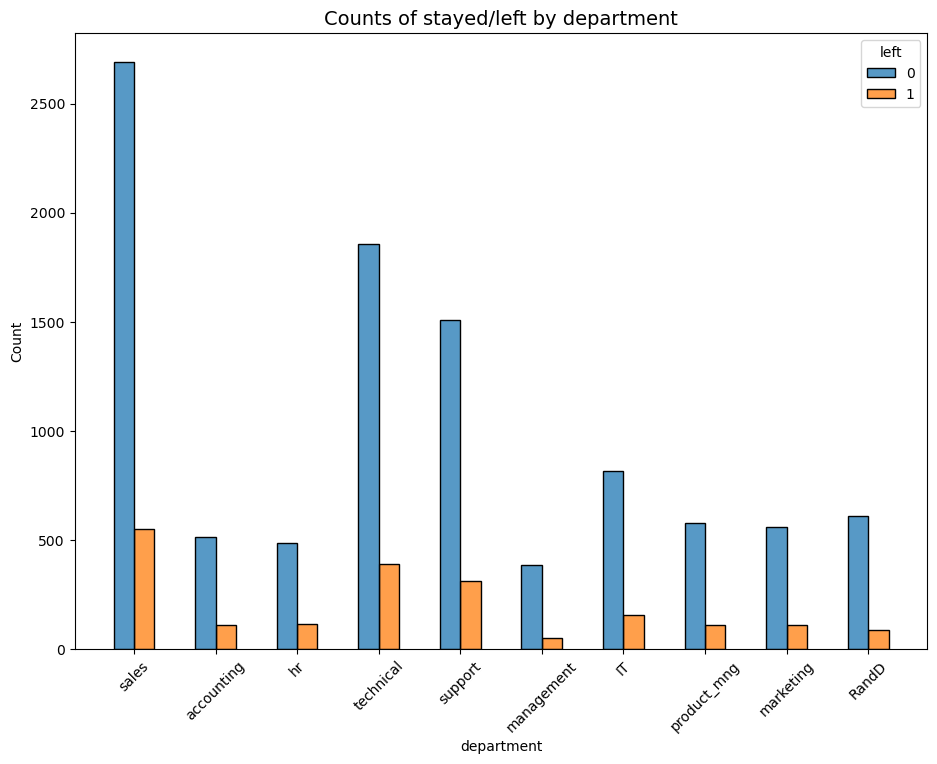

In [23]:
# Create stacked histogram to compare department distribution of employees who left to that of employees who didn't
plt.figure(figsize=(11,8))
sns.histplot(data=df1, x='department', hue='left', discrete=1, 
             hue_order=[0, 1], multiple='dodge', shrink=.5)
plt.xticks(rotation=45)
plt.title('Counts of stayed/left by department', fontsize=14);


* **No departmental bias:** There's no significant difference in the proportion of leavers across departments.

Next, I look for strong correlations between variables.

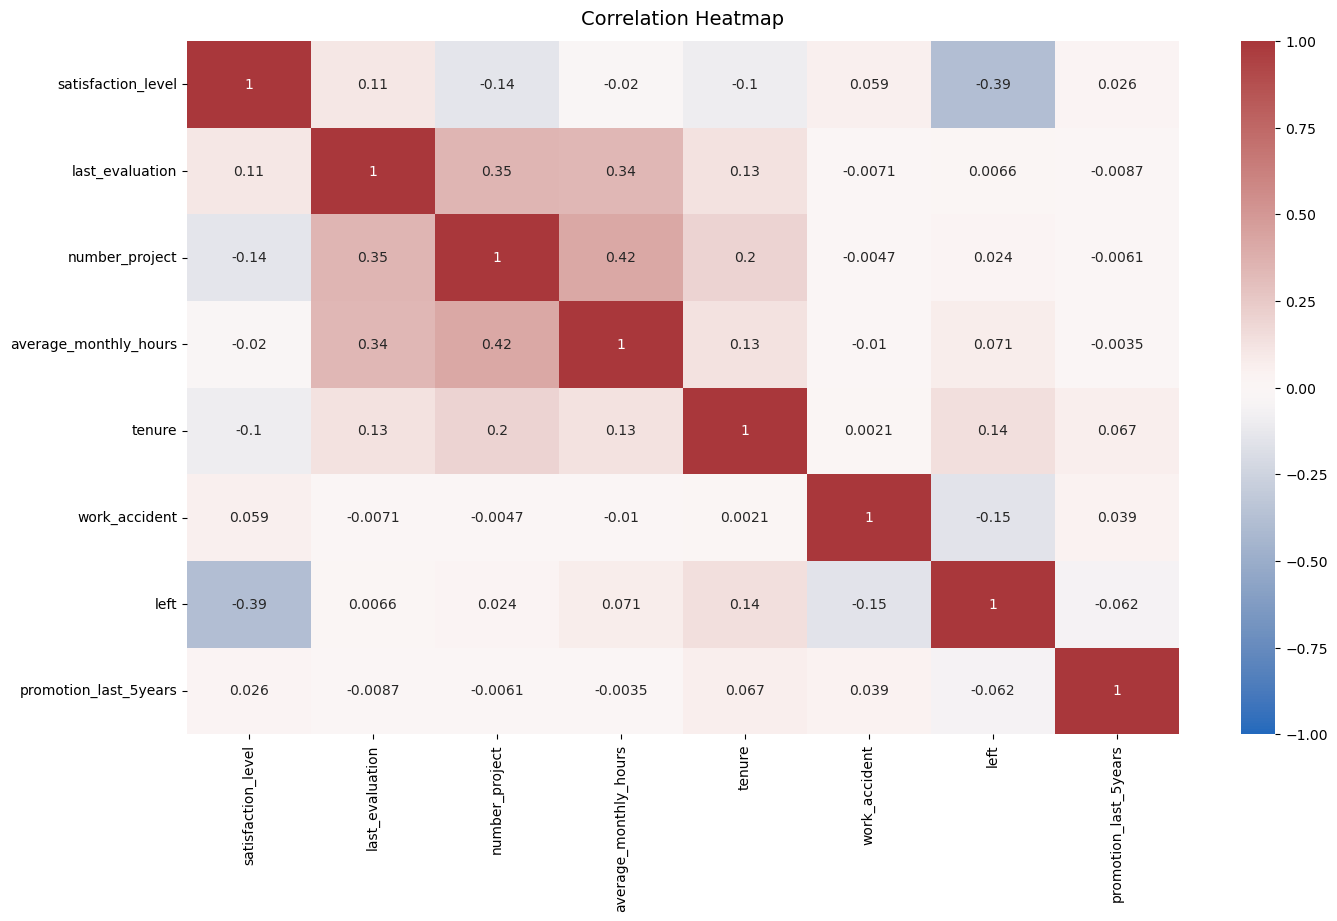

In [27]:
# Plot a correlation heatmap
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(df0.corr(numeric_only = True), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

1. **Positive correlations:** Number of projects, monthly hours, and evaluation scores are positively correlated.
2. **Negative correlation:** Leaving the company is negatively correlated with satisfaction levels.

### Insights

1. **Poor management:** Employees are likely leaving due to long working hours, many projects, low satisfaction levels, lack of promotions, and poor evaluations.
2. **Burnout is common:** Many employees are likely experiencing burnout.
3. **Long-term loyalty:** Employees with more than six years at the company tend not to leave.

## Model Building and Evaluation

1. **Goal:** Predict if an employee will leave the company. This is a binary classification task as the outcome variable `left` can take two values: 1 (employee left) or 0 (employee stayed).

2. **Method:** Since the target variable is categorical, I  build two types of models: Logistic Regression and Tree-based Machine Learning models, and compare them.

### Modeling Approach A: Logistic Regression Model

1. **Prepare data for modeling:** Encode non-numeric variables before splitting the data. There are two such variables: `department` and `salary`.

2. **Encode `department`:** Since `department` is a categorical variable with no inherent order, create dummy variables for it.

3. **Encode `salary`:** `salary` is an ordinal variable, meaning its categories have a natural order. Instead of creating dummy variables, convert the levels to numeric values (e.g., 0–2).

In [25]:
# Copy the dataframe
df_enc = df1.copy()

# Encode the `salary` column as an ordinal numeric category
df_enc['salary'] = (
    df_enc['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)

# Dummy encode the `department` column
df_enc = pd.get_dummies(df_enc, drop_first=False)

# Display the new dataframe
df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


Create a heatmap to visualize how correlated variables are.

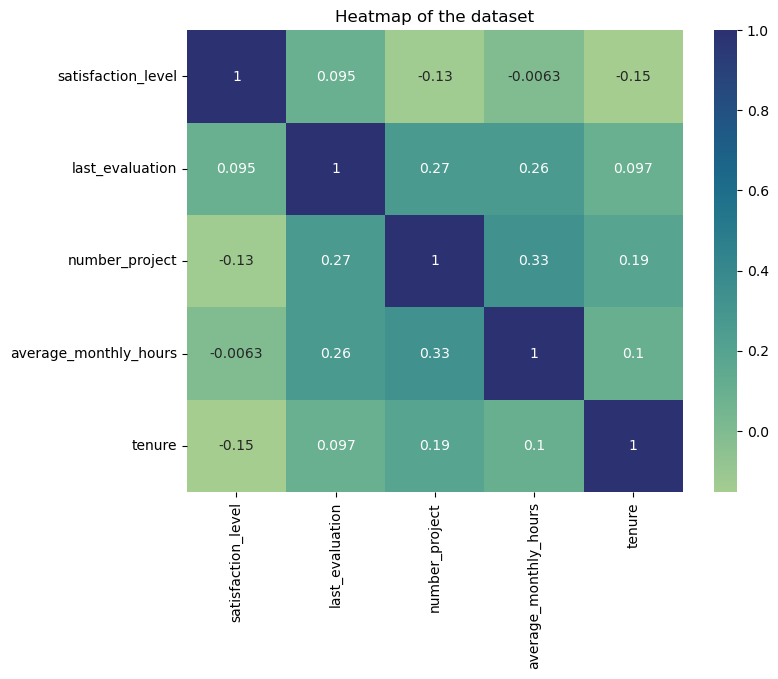

In [26]:
# Create a heatmap to visualize how correlated variables are
plt.figure(figsize=(8, 6))
sns.heatmap(df_enc[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']]
            .corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

Create a stacked bar plot to visualize number of employees across department, comparing those who left with those who didn't.

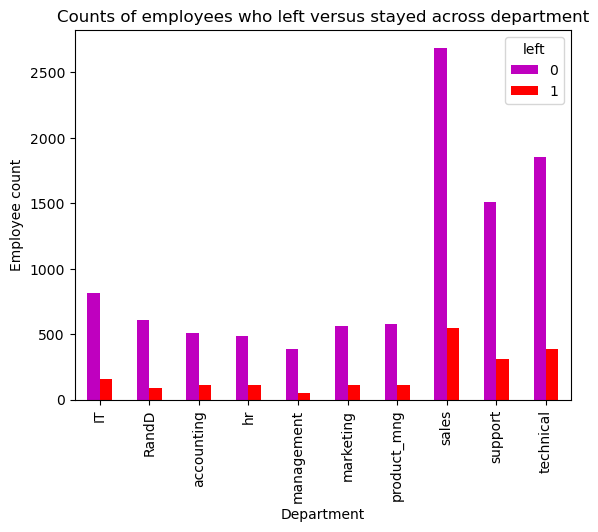

In [27]:
# Create a stacked bart plot to visualize number of employees across department, comparing those who left with those who didn't
# In the legend, 0 (purple color) represents employees who did not leave, 1 (red color) represents employees who left
pd.crosstab(df1['department'], df1['left']).plot(kind ='bar',color='mr')
plt.title('Counts of employees who left versus stayed across department')
plt.ylabel('Employee count')
plt.xlabel('Department')
plt.show()

Since logistic regression is quite sensitive to outliers, it would be a good idea at this stage to remove the outliers in the `tenure` column that were identified earlier.

In [28]:
# Select rows without outliers in `tenure` and save resulting dataframe in a new variable
df_logreg = df_enc[(df_enc['tenure'] >= lower_limit) & (df_enc['tenure'] <= upper_limit)]

# Display first few rows of new dataframe
df_logreg.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
5,0.41,0.50,2,153,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


Isolate the outcome variable, which is the variable I want my model to predict.

In [29]:
# Isolate the outcome variable
y = df_logreg['left']

# Display first few rows of the outcome variable
y.head() 

0    1
2    1
3    1
4    1
5    1
Name: left, dtype: int64

Select the features that will help predict the outcome variable, `left`.

In [30]:
# Select the features I want to use in my model
X = df_logreg.drop('left', axis=1)

# Display the first few rows of the selected features 
X.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,0,0,1,0,0
5,0.41,0.50,2,153,3,0,0,0,0,0,0,0,0,0,0,1,0,0


Split the data into training set and testing set. Stratify based on the values in `y`, since the classes are unbalanced.

In [31]:
# Split the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

Construct a logistic regression model and fit it to the training dataset.

In [32]:
# Construct a logistic regression model and fit it to the training dataset
log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)

Test the logistic regression model by making predictions on the test set.

In [33]:
# Use the logistic regression model to get predictions on the test set
y_pred = log_clf.predict(X_test)

Create a confusion matrix to visualize the results of the logistic regression model. 

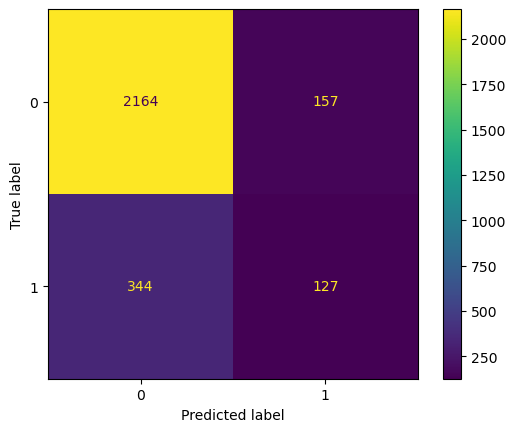

In [34]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

# Display plot
plt.show()

1. **True Negatives (upper-left):** Count of employees correctly predicted by the model as not leaving.

2. **False Positives (upper-right):** Count of employees incorrectly predicted by the model as leaving, but they actually did not leave.

3. **False Negatives (bottom-left):** Count of employees incorrectly predicted by the model as not leaving, but they actually left.

4. **True Positives (bottom-right):** Count of employees correctly predicted by the model as leaving.

The ideal model would have all true positives and true negatives, with no false positives or false negatives.

### Evaluation

Generate a report including precision, recall, f1-score, and accuracy to assess the Logistic Regression model's performance.

**Check Class Balance:** Inspect the distribution of values in the `left` column. This will help understand and interpret the model's accuracy.

In [35]:
df_logreg['left'].value_counts(normalize=True)

0    0.831468
1    0.168532
Name: left, dtype: float64

**Class Balance:** The data is divided approximately 83%–17%, making it not perfectly balanced but not too imbalanced either. If it were more severely imbalanced, resampling might be needed to adjust the class balance.

In [36]:
# Create classification report for logistic regression model
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.93      0.90      2321
    Predicted would leave       0.45      0.27      0.34       471

                 accuracy                           0.82      2792
                macro avg       0.66      0.60      0.62      2792
             weighted avg       0.79      0.82      0.80      2792



**Model Evaluation:** The Logistic Regression model achieved a weighted average precision of 79%, recall of 82%, f1-score of 80%, and overall accuracy of 82%. However, the model's performance dropped significantly when predicting employees who leave.

### Modeling Approach B: Tree-based Model (Decision Tree and Random Forest)

Isolate the outcome variable.

In [37]:
# Isolate the outcome variable
y = df_enc['left']

# Display the first few rows of `y`
y.head()

0    1
1    1
2    1
3    1
4    1
Name: left, dtype: int64

Select the features. 

In [38]:
# Select the features
X = df_enc.drop('left', axis=1)

# Display the first few rows of `X`
X.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,0,0,1,0,0


Split the data into training, validating, and testing sets.

In [39]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

#### Decision tree - Round 1

Construct a decision tree model and set up cross-validated grid-search to exhuastively search for the best model parameters.

In [42]:
# Instantiate model
tree = DecisionTreeClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearch
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

Fit the decision tree model to the training data.

In [43]:
%%time
tree1.fit(X_train, y_train)

CPU times: total: 14.6 s
Wall time: 15.1 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

Identify the optimal values for the decision tree parameters.

In [44]:
# Check best parameters
tree1.best_params_

{'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}

Identify the best AUC score achieved by the decision tree model on the training set.

In [45]:
# Check best AUC score on CV
tree1.best_score_

0.969819392792457

This is a strong AUC score, which shows that this model can predict employees who will leave very well.

Next, I write a function that helps me extract all the scores from the grid search. 

In [46]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc
  
    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
    return table

Use the function just defined to get all the scores from grid search.

In [47]:
# Get all CV scores
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
tree1_cv_results

,model,precision,recall,F1,accuracy,auc
0,decision tree cv,0.914552,0.916949,0.915707,0.971978,0.969819


All of these scores from the decision tree model are strong indicators of good model performance. 

Since decision trees can be vulnerable to overfitting, and random forests avoid overfitting by incorporating multiple trees to make predictions. I construct a random forest model next.

#### Random forest - Round 1

Construct a random forest model and set up cross-validated grid-search to exhuastively search for the best model parameters.

In [50]:
# Instantiate model
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

# Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

Fit the random forest model to the training data.

In [51]:
%%time
rf1.fit(X_train, y_train) # --> Wall time: ~10min

Specify path to where I want to save my model.

In [ ]:
# Define a path to the folder where you want to save the model
path = '/'

Define functions to pickle the model and read in the model.

In [ ]:
def write_pickle(path, model_object, save_as:str):
    '''
    In: 
        path:         path of folder where you want to save the pickle
        model_object: a model you want to pickle
        save_as:      filename for how you want to save the model

    Out: A call to pickle the model in the folder indicated
    '''    

    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [ ]:
def read_pickle(path, saved_model_name:str):
    '''
    In: 
        path:             path to folder where you want to read from
        saved_model_name: filename of pickled model you want to read in

    Out: 
        model: the pickled model 
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

Use the functions defined above to save the model in a pickle file and then read it in.

In [ ]:
# Write pickle
write_pickle(path, rf1, 'hr_rf1')

In [ ]:
# Read pickle
rf1 = read_pickle(path, 'hr_rf1')

Identify the best AUC score achieved by the random forest model on the training set.

In [ ]:
# Check best AUC score on CV
rf1.best_score_

0.9804250949807172

Identify the optimal values for the parameters of the random forest model.

In [ ]:
# Check best params
rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 500}

Collect the evaluation scores on the training set for the decision tree and random forest models.

In [ ]:
# Get all CV scores
rf1_cv_results = make_results('random forest cv', rf1, 'auc')
print(tree1_cv_results)
print(rf1_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.914552  0.916949  0.915707  0.971978  0.969819
              model  precision    recall        F1  accuracy       auc
0  random forest cv   0.950023  0.915614  0.932467  0.977983  0.980425


The Random Forest model performs better than the Decision Tree model in terms of evaluation scores, except for a negligible difference in recall (around 0.001 lower in the Random Forest model). This suggests that the Random Forest model is generally more effective.

Next, I evaluate the final model on the test set.

Define a function that gets all the scores from a model's predictions.

In [ ]:
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision], 
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]
                         })
  
    return table

Now use the best performing model to predict on the test set.

In [ ]:
# Get predictions on test data
rf1_test_scores = get_scores('random forest1 test', rf1, X_test, y_test)
rf1_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest1 test,0.964211,0.919679,0.941418,0.980987,0.956439


The test scores are very similar to the validation scores, which is good. This appears to be a strong model. Since this test set was only used for this model, I can be more confident that my model's performance on this data is representative of how it will perform on new, unseeen data.

#### Refining the Model by Feature Engineering

1. **High Evaluation Scores:** I'm skeptical of the high model scores and suspect potential data leakage, which could lead to unrealistically high performance during training that won't replicate in a real-world scenario.

2. **Potential Data Leakage Sources:** I identified potential sources of leakage as `satisfaction_level` and `average_monthly_hours`. It's likely that the company might not have satisfaction levels for all employees, and those planning to quit or being identified for termination may be working fewer hours.

3. **Feature Engineering Approach:** To refine the models, I plan to:
   - Drop the `satisfaction_level` feature, which could be leaking information.
   - Create a new binary feature named `overworked` to identify if an employee is potentially overworked.

This revised set of features will be used in the next round of modeling.

In [ ]:
# Drop `satisfaction_level` and save resulting dataframe in new variable
df2 = df_enc.drop('satisfaction_level', axis=1)

# Display first few rows of new dataframe
df2.head()

,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Create `overworked` column. For now, it's identical to average monthly hours.
df2['overworked'] = df2['average_monthly_hours']

# Inspect max and min average monthly hours values
print('Max hours:', df2['overworked'].max())
print('Min hours:', df2['overworked'].min())

Max hours: 310
Min hours: 96


166.67 is approximately the average number of monthly hours for someone who works 50 weeks per year, 5 days per week, 8 hours per day. 

I define being overworked as working more than 175 hours per month on average.

To make the `overworked` column binary, I reassign the column using a boolean mask.
- `df3['overworked'] > 175` creates a series of booleans, consisting of `True` for every value > 175 and `False` for every values ≤ 175
- `.astype(int)` converts all `True` to `1` and all `False` to `0` 

In [ ]:
# Define `overworked` as working > 175 hrs/week
df2['overworked'] = (df2['overworked'] > 175).astype(int)

# Display first few rows of new column
df2['overworked'].head()

0    0
1    1
2    1
3    1
4    0
Name: overworked, dtype: int64

Drop the `average_monthly_hours` column.



In [ ]:
# Drop the `average_monthly_hours` column
df2 = df2.drop('average_monthly_hours', axis=1)

# Display first few rows of resulting dataframe
df2.head()

,last_evaluation,number_project,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,overworked
0,0.53,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0.86,5,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
2,0.88,7,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
3,0.87,5,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
4,0.52,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


Again, isolate the features and target variables

In [ ]:
# Isolate the outcome variable
y = df2['left']

# Select the features
X = df2.drop('left', axis=1)

Split the data into training and testing sets.

In [ ]:
# Create test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

#### Decision tree - Round 2

In [ ]:
# Instantiate model
tree = DecisionTreeClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
tree2 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [ ]:
%%time
tree2.fit(X_train, y_train)

CPU times: user 2.49 s, sys: 1.36 ms, total: 2.49 s
Wall time: 2.49 s


GridSearchCV(cv=4, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                

In [ ]:
# Check best params
tree2.best_params_

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6}

In [ ]:
# Check best AUC score on CV
tree2.best_score_

0.9586752505340426

This model performs very well, even without satisfaction levels and detailed hours worked data. 

Next, check the other scores.

In [ ]:
# Get all CV scores
tree2_cv_results = make_results('decision tree2 cv', tree2, 'auc')
print(tree1_cv_results)
print(tree2_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.914552  0.916949  0.915707  0.971978  0.969819
               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.856693  0.903553  0.878882  0.958523  0.958675


Some of the other scores fell. That's to be expected given fewer features were taken into account in this round of the model. Still, the scores are very good.

#### Random forest - Round 2

In [ ]:
# Instantiate model
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
rf2 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [ ]:
%%time
rf2.fit(X_train, y_train) # --> Wall time: 7min 5s

CPU times: user 7min 10s, sys: 1.17 s, total: 7min 11s
Wall time: 7min 11s


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,...
                                              verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
# Write pickle
write_pickle(path, rf2, 'hr_rf2')

In [ ]:
# Read in pickle
rf2 = read_pickle(path, 'hr_rf2')

In [ ]:
# Check best params
rf2.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [ ]:
# Check best AUC score on CV
rf2.best_score_

0.9648100662833985

In [ ]:
# Get all CV scores
rf2_cv_results = make_results('random forest2 cv', rf2, 'auc')
print(tree2_cv_results)
print(rf2_cv_results)

               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.856693  0.903553  0.878882  0.958523  0.958675
               model  precision    recall        F1  accuracy      auc
0  random forest2 cv   0.866758  0.878754  0.872407  0.957411  0.96481


Again, the scores dropped slightly, but the random forest performs better than the decision tree if using AUC as the deciding metric. 

Score the champion model on the test set now.

In [ ]:
# Get predictions on test data
rf2_test_scores = get_scores('random forest2 test', rf2, X_test, y_test)
rf2_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest2 test,0.870406,0.903614,0.8867,0.961641,0.938407


This seems to be a stable, well-performing final model. 

Plot a confusion matrix to visualize how well it predicts on the test set.

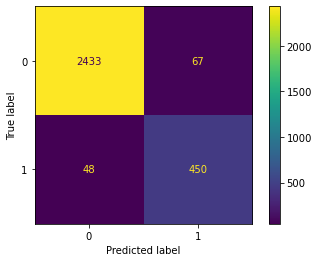

In [ ]:
# Generate array of values for confusion matrix
preds = rf2.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf2.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf2.classes_)
disp.plot(values_format='');

1. **Model Evaluation:** The model tends to predict more false positives than false negatives. This implies that some employees may be incorrectly flagged as at risk of leaving the company. Despite this, the model's overall performance is strong.

2. **Further Exploration:** I'm interested in investigating the decision tree model's splits further and determining which features are most important in the random forest model.

#### Decision tree splits

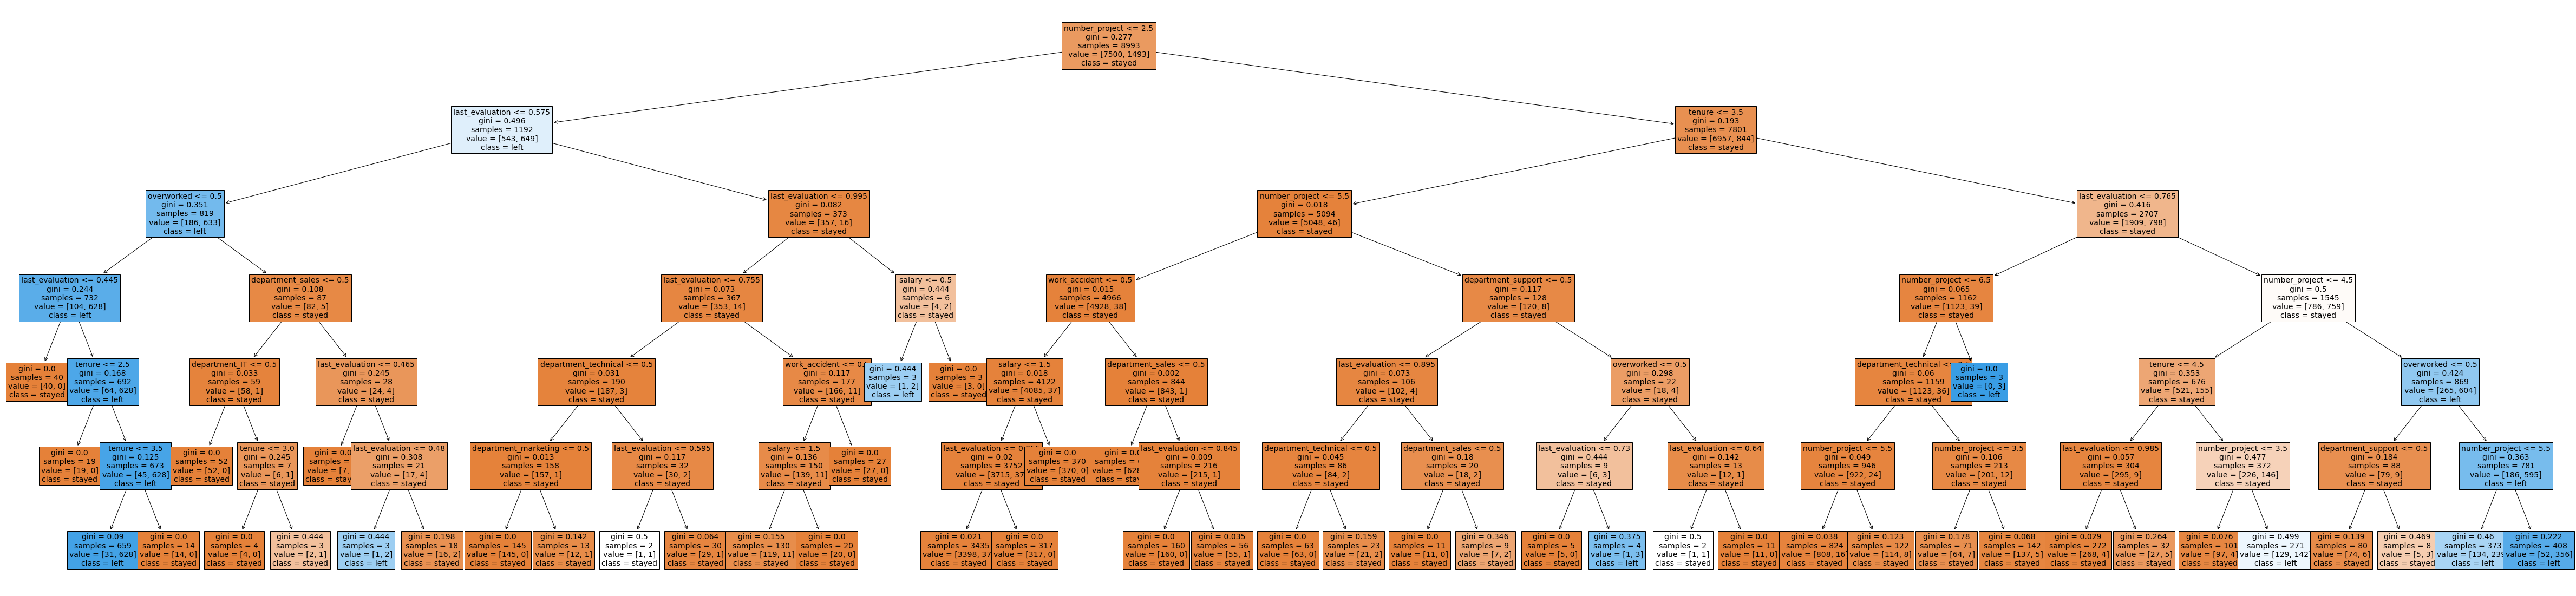

In [ ]:
# Plot the tree
plt.figure(figsize=(85,20))
plot_tree(tree2.best_estimator_, max_depth=6, fontsize=14, feature_names=X.columns, 
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

#### Decision tree feature importance

I get feature importance from decision trees.

In [ ]:
#tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, columns=X.columns)
tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, 
                                 columns=['gini_importance'], 
                                 index=X.columns
                                )
tree2_importances = tree2_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
tree2_importances = tree2_importances[tree2_importances['gini_importance'] != 0]
tree2_importances

,gini_importance
last_evaluation,0.343958
number_project,0.343385
tenure,0.215681
overworked,0.093498
department_support,0.001142
salary,0.000910
department_sales,0.000607
department_technical,0.000418
work_accident,0.000183
department_IT,0.000139


I then create a barplot to visualize the decision tree feature importances.

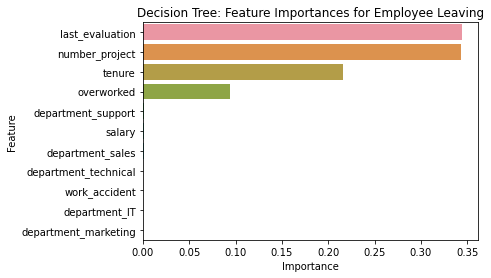

In [ ]:
sns.barplot(data=tree2_importances, x="gini_importance", y=tree2_importances.index, orient='h')
plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()


The barplot above shows that in this decision tree model, `last_evaluation`, `number_project`, `tenure`, and `overworked` have the highest importance, in that order. These variables are most helpful in predicting the outcome variable, `left`.

#### Random forest feature importance

Now, plot the feature importances for the random forest model.

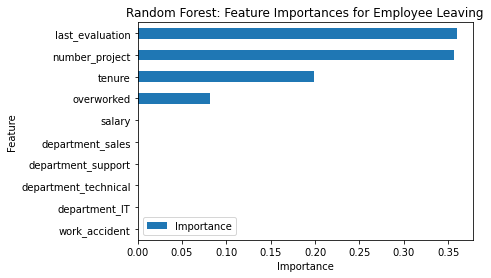

In [ ]:
# Get feature importances
feat_impt = rf2.best_estimator_.feature_importances_

# Get indices of top 10 features
ind = np.argpartition(rf2.best_estimator_.feature_importances_, -10)[-10:]

# Get column labels of top 10 features 
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

The plot above shows that in this random forest model, `last_evaluation`, `number_project`, `tenure`, and `overworked` have the highest importance, in that order. These variables are most helpful in predicting the outcome variable, `left`, and they are the same as the ones used by the decision tree model.

## Summary of model results on test set


| Model               | Precision | Recall | F1-Score | Accuracy | AUC    |
|---------------------|-----------|--------|----------|----------|--------|
| Logistic Regression | 79%       | 82%    | 80%      | 82%      | N/A    |
| Random Forest (After feature engineering)      | 87%       | 90.4%  | 88.7%    | 96.2%    | 93.8%  |



## Conclusion and Recommendations

The models and their feature importances suggest that the company's employees are overworked.

To improve employee retention, the following steps could be suggested to stakeholders:

* Limit the number of projects assigned to each employee.
* Evaluate promoting employees who have been with the company for at least four years, or investigate why such employees are dissatisfied. 
* Reward employees for working longer hours, or avoid demanding extra hours. 
* Ensure employees are aware of the company's overtime policies. If workload and time off expectations are not clear, clarify them. 
* Facilitate discussions company-wide and within teams to address the company's work culture.
* Avoid reserving high evaluation scores for employees who work over 200 hours per month. Instead, consider a scale that rewards employees proportionately for their effort and contribution. 

## Way Forward

As a follow-up:

* Investigate potential data leakage further by exploring how predictions change when `last_evaluation` is removed. This could be useful if evaluations are infrequent or if they significantly impact an employee's decision to stay or leave.
* Consider using a K-means model to analyze the data. Analyzing the resulting clusters might provide additional insight.